# Character Predicting with RNN
---

Codes are writen by simonjisu.
* Simonjisu Blog: https://simonjisu.github.io
* Project Numpy with NN: https://github.com/simonjisu/NUMPYwithNN



## Goal
Writing 'Hello world! Nice to meet you! I love iron-man' using RNN with numpy

|Input||Output|
|:-:|:-:|:-:|
|h|$\rightarrow$|e|
|e|$\rightarrow$|l|
|l|$\rightarrow$|l|
|l|$\rightarrow$|o|
|$\vdots$|$\vdots$|$\vdots$|
|m|$\rightarrow$|a|
|a|$\rightarrow$|n|


## Packages

In [1]:
import os
import sys
dir_path = '/'.join(os.getcwd().split('/')[:-1])
sys.path.append(dir_path)

In [2]:
import numpy as np
from common.SimpleRNN import Single_layer_RNN
from common.optimizer import Adam
from common.train_graph import loss_graph
np.random.seed(1234)

## DATA

In [3]:
x = 'hello world! nice to meet you! i love iron-man'

### Encoder

In [4]:
class chr_coding(object):
    def __init__(self):
        self._dict = None
        self._one_hot_matrix = None
        self._dict_reversed = None
        
    def fit(self, x):
        if isinstance(x, str):
            x = list(x)
        
        self._one_hot_matrix = np.eye(len(set(x)))
        self._dict = {d: i for i, d in enumerate(list(set(x)))}
        self._dict_reversed = {v: k for k, v in self._dict.items()}
        
    def encode(self, x):
        encoded_data = np.array([self._one_hot_matrix[self._dict[d]] for d in x])
        return encoded_data
    
    def decode(self, x, probs=None):
        if probs is None:
            decoded_data = self._dict_reversed[x]
        else:
            decoded_data = self._dict_reversed[np.argmax(probs)]
        return decoded_data

Change our data to one-hot encoding data by single character. 

In [5]:
encoder = chr_coding()
encoder.fit(x)
one_hot_data = encoder.encode(x)

print('data shape:', one_hot_data.shape)

data shape: (46, 19)


## Parameters

In [6]:
NUM_EPOCHS = 600
PRINT_EPOCH = 30
SEQ_LEN = one_hot_data.shape[0] - 1
INPUT_SIZE = one_hot_data.shape[1]
OUTPUT_SIZE = one_hot_data.shape[1]
HIDDEN_SIZE = 20
BPTT_TRUNCATE = 5

# Backpropagation Through Time Truncate: 
# A fixed number of steps to lookback past data in BPTT

## Get Training Datas

In [7]:
train_x = one_hot_data[:-1]
train_y = one_hot_data[1:]

In [8]:
train_x.shape

(45, 19)

## Call RNN module & Optimizer Setting

Basic Settings of **Single_layer_RNN**

* input_size: input layer size
* hidden_size: hidden layer size
* output_size: output layer size
* bptt_truncate: if you want to use it, use backward_truncate method when you doing backward, default=0
* activation_func: if use "tanh", params will initialize as Xavier, use "relu", initialize as He, default="tanh"

In [9]:
# accuracy calculation function
def get_accuracy(x, test_string):
    bool_ = np.array(list(x))[1:] == np.array(list(test_string))[1:]
    return bool_.sum() / len(bool_)

In [10]:
def train(rnn, optim, option=True, print_epoch=20):
    """
    option:
    * True: do backward
    * False: do backward_truncate
    """
    total_loss_list = []
    total_acc_list = []
    for epoch in range(NUM_EPOCHS):
        test_string = 'h'
        # forward
        total_loss = rnn.loss(train_x, train_y)

        # backward
        if option:
            rnn.backward()
        else:
            rnn.backward_truncate()

        optim.update(rnn.params, rnn.params_summ)

        # test string
        predicted_idx = rnn.predict(train_x)
        for idx in predicted_idx:
            test_string += encoder.decode(idx)

        # get accuracy
        acc = get_accuracy(x, test_string)

        if epoch % print_epoch == 0:
            print('#{0}, Loss: {1:.6f}, Acc: {2:.6f}, Test_string: "{3}"'\
                  .format(epoch, total_loss, acc, test_string))
        elif epoch == (NUM_EPOCHS-1):
            print('#{0}, Loss: {1:.6f}, Acc: {2:.6f}, Test_string: "{3}"'\
                  .format(epoch, total_loss, acc, test_string))

        total_loss_list.append(total_loss)
        total_acc_list.append(acc)
    return total_loss_list, total_acc_list

### Using BPTT

In [11]:
rnn = Single_layer_RNN(input_size=INPUT_SIZE, 
                       hidden_size=HIDDEN_SIZE, 
                       output_size=OUTPUT_SIZE)
optim = Adam()

In [12]:
total_loss_list, total_acc_list = train(rnn, optim, option=True, print_epoch=PRINT_EPOCH)

#0, Loss: 2.965270, Acc: 0.044444, Test_string: "hu-dwccdiiwctvrrwcvrrocciracattiwccciirrccr  o"
#30, Loss: 2.586760, Acc: 0.244444, Test_string: "hu-dwvitrao!tiirocviiroctiioottirrovtiiro!tiir"
#60, Loss: 2.336385, Acc: 0.266667, Test_string: "hu-d!vi roo!tiiro!tiiro!tiioo!tiiro!tiiro!t ir"
#90, Loss: 2.134574, Acc: 0.400000, Test_string: "hu-d! iiroo!tiiroet ireet ioo!tiirovt iro!t ir"
#120, Loss: 1.933423, Acc: 0.533333, Test_string: "he-d! iorod! iireet ileet ioe!  irovt iro!- ir"
#150, Loss: 1.718874, Acc: 0.577778, Test_string: "he-do iorod! iirevt  leet ioe!  irovt irov- ic"
#180, Loss: 1.500107, Acc: 0.755556, Test_string: "heldo worod! iirevt  meet ioe! iilovt iron- an"
#210, Loss: 1.285597, Acc: 0.755556, Test_string: "heloo worod! iirevt  meet ioe! iilovt iron- an"
#240, Loss: 1.085051, Acc: 0.822222, Test_string: "heloo worod! iicevto meet ioe! iilovt iron-man"
#270, Loss: 0.902094, Acc: 0.911111, Test_string: "hello world! iicevto meet iou! iilove iron-man"
#300, Loss: 0.7

In [13]:
rnn.gradient_check(train_x, train_y)

W_xh:0.027208891740426153
W_hh:0.057702639857981845
W_hy:0.09827134346354681
b_h:0.003190582939974207
b_y:0.002550249248145801


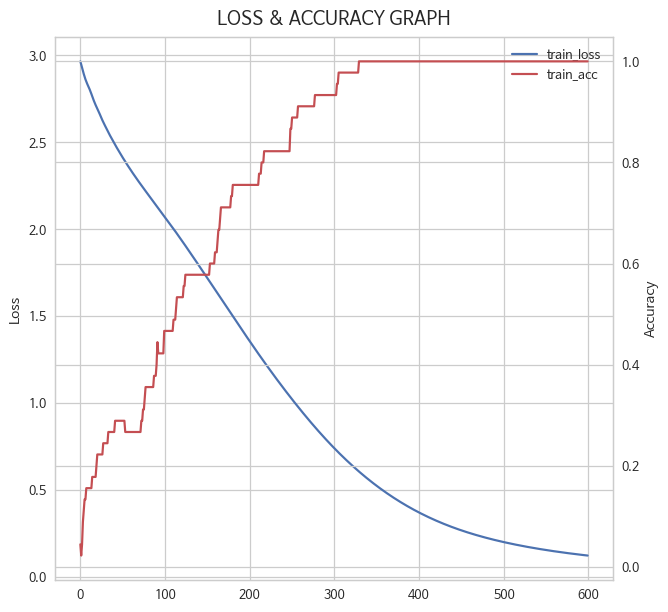

In [14]:
loss_graph(train_loss_list=total_loss_list, train_acc_list=total_acc_list)

### Using BPTT-Truncate

In [15]:
rnn = Single_layer_RNN(input_size=INPUT_SIZE, 
                       hidden_size=HIDDEN_SIZE, 
                       output_size=OUTPUT_SIZE,
                       bptt_truncate=BPTT_TRUNCATE)
optim = Adam()

In [16]:
total_loss_list, total_acc_list = train(rnn, optim, option=False, print_epoch=PRINT_EPOCH)

#0, Loss: 2.989375, Acc: 0.022222, Test_string: "hcaaacrh!--yvc-nlacm!o-rlarlclhn-no!lac-!crcl!"
#30, Loss: 2.738472, Acc: 0.155556, Test_string: "hcaaocro!- yac-nlawo!o-nltclc- n-nocoao- c-ml!"
#60, Loss: 2.509577, Acc: 0.333333, Test_string: "hcwloowo!- n no oooo oeno no - nwnoooooo o men"
#90, Loss: 2.301227, Acc: 0.355556, Test_string: "hcwlooro!- i n   ooo oeeo to!! n  o oooo o me "
#120, Loss: 2.135386, Acc: 0.422222, Test_string: "hclloororm   i    oo oeeo tu!! i      o    men"
#150, Loss: 2.018462, Acc: 0.444444, Test_string: "hclloororm!! ii  ooo oeet tuu!!i     oooooeeat"
#180, Loss: 2.085227, Acc: 0.422222, Test_string: "hcllooror!!! i   ooo oeeo      i      o oo men"
#210, Loss: 1.954691, Acc: 0.400000, Test_string: "hclloowormu!!!i i  o oertatou!!!ii     oeertat"
#240, Loss: 1.916078, Acc: 0.533333, Test_string: "hcll  woroo! ni i io ooeo no!! i i      o emen"
#270, Loss: 2.290405, Acc: 0.333333, Test_string: "h ll  io          o        o   i  o          n"
#300, Loss: 2.2

In [17]:
rnn.gradient_check(train_x, train_y)

W_xh:2.308744753593391
W_hh:6.664503085071583
W_hy:0.18789688978257824
b_h:0.10718435894752076
b_y:0.004499740859569512


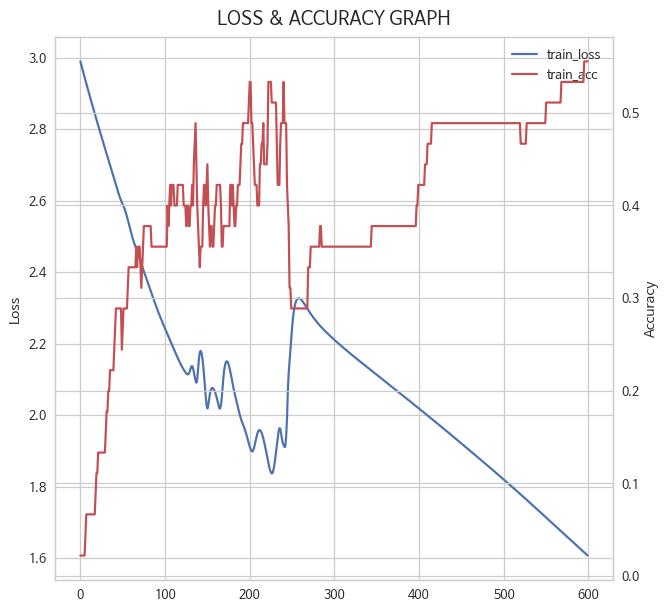

In [18]:
loss_graph(train_loss_list=total_loss_list, train_acc_list=total_acc_list)

### Using ReLu as activation functions

In [19]:
rnn = Single_layer_RNN(input_size=INPUT_SIZE, 
                       hidden_size=HIDDEN_SIZE, 
                       output_size=OUTPUT_SIZE,
                       bptt_truncate=BPTT_TRUNCATE,
                       activation_func='relu')
optim = Adam()

In [20]:
total_loss_list, total_acc_list = train(rnn, optim, option=True, print_epoch=PRINT_EPOCH)

#0, Loss: 3.733362, Acc: 0.022222, Test_string: "howyy-wwwwiuwy wwwywywwwwwwwwwwywwywwwwww-yyww"
#30, Loss: 3.239020, Acc: 0.044444, Test_string: "howoy-ow w uiy ww y owwwwwww-ywy!iow!yuww-yy-o"
#60, Loss: 3.002164, Acc: 0.111111, Test_string: "howoouow w oiy wl o owwwwwowwy y!io ! uuyo i-o"
#90, Loss: 2.827660, Acc: 0.155556, Test_string: "howoo ow w oiy wl o owwww owwy o!io ! ouyo  -h"
#120, Loss: 2.684567, Acc: 0.200000, Test_string: "howoo ow ! oio wl o oow w oooy o io ! ooy   -o"
#150, Loss: 2.550226, Acc: 0.222222, Test_string: "howoo ow o o o !l o oow o oo o o io ! ooy   -o"
#180, Loss: 2.422392, Acc: 0.333333, Test_string: "hewoo oo o o o cl o ooo o oo o o io ! ooo   -n"
#210, Loss: 2.288477, Acc: 0.333333, Test_string: "hewoo oo o o o cl o oo  o oo o o io ! ooo   -n"
#240, Loss: 2.151459, Acc: 0.355556, Test_string: "hewoo oo o o o cl o  o  i oo o o io !   o   -n"
#270, Loss: 2.001961, Acc: 0.400000, Test_string: "hewoo oo o o o cl io o  i oo o l io ! i o   -n"
#300, Loss: 1.8

In [21]:
rnn.gradient_check(train_x, train_y)

W_xh:0.2695099077515012
W_hh:2.234925626296334
W_hy:0.2030214068865176
b_h:0.11043919379034872
b_y:0.003923439089638161


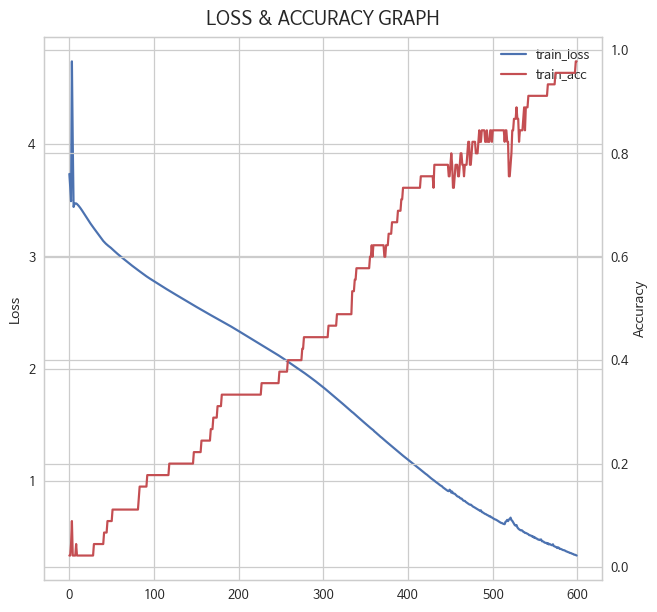

In [22]:
loss_graph(train_loss_list=total_loss_list, train_acc_list=total_acc_list)